## Load Data

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import warnings
warnings.filterwarnings('ignore')

In [77]:
# Adjust paths as needed
patient_df = pd.read_csv("../../data/thesis/cll_broad_2022_clinical_data_thesis.csv")
mutation_df = pd.read_csv("../../data/thesis/cll_broad_2022_mutations_thesis.csv")
community_df = pd.read_csv("../data/full/w_slpa/community_assignments.csv")

In [78]:
# Identify overlapping patients
comm_count = community_df.groupby('patientId').size().reset_index(name='comm_count')
overlapping = comm_count[comm_count['comm_count'] > 1]['patientId']
community_df['is_overlap'] = community_df['patientId'].isin(overlapping)
merged = pd.merge(community_df, patient_df, on='patientId')

merged.shape

(1062, 31)

## Define Group Extraction Functions

In [79]:
def get_overlap_groups(community_df, comm_id_1, comm_id_2):
    """
    Returns dict with keys:
    - f'[{comm_id_1}]': patientIds only in comm_id_1
    - f'[{comm_id_2}]': patientIds only in comm_id_2
    - f'[{comm_id_1},{comm_id_2}]': patientIds in both
    """
    # Overlap group
    overlap_pairs = community_df[community_df['is_overlap']].groupby('patientId')['communityId'].apply(sorted).reset_index()
    overlap_pairs['comm_pair'] = overlap_pairs['communityId'].apply(lambda x: str(x))
    comm_pair_str = f'[{comm_id_1}, {comm_id_2}]'
    overlap = set(overlap_pairs[overlap_pairs['comm_pair'] == comm_pair_str]['patientId'])
    # Only in 1
    only_1 = set(community_df[(community_df['communityId'] == comm_id_1) & (~community_df['is_overlap'])]['patientId'])
    # Only in 2
    only_2 = set(community_df[(community_df['communityId'] == comm_id_2) & (~community_df['is_overlap'])]['patientId'])
    return {
        f'[{comm_id_1}]': only_1,
        f'[{comm_id_2}]': only_2,
        f'[{comm_id_1},{comm_id_2}]': overlap
    }

## Plotting Functions

In [80]:
def plot_overlap_group_figure(
    merged, comm1, comm2, group_dict, 
    legend_mapping, 
    numeric_features=['AGE_SAMPLING', 'MUTATION_COUNT'],
    categorical_features=['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE'],
    figsize=(18, 10)
):
    """
    merged: merged DataFrame with patient info
    comm1, comm2: int, community ids
    group_dict: dict with keys '[comm1]', '[comm2]', '[comm1,comm2]' and sets of patientIds
    legend_mapping: dict of {feature: {category: color}}
    """
    # Order: comm1, overlap, comm2
    group_labels = [f'[{comm1}]', f'[{comm1},{comm2}]', f'[{comm2}]']
    # Build DataFrame with group label
    group_dfs = []
    for label in group_labels:
        ids = group_dict[label]
        sub = merged[merged['patientId'].isin(ids)].copy()
        sub['overlap_group'] = label
        group_dfs.append(sub)
    plot_df = pd.concat(group_dfs, axis=0)
    
    # Layout: 2 rows × 3 cols (last cell empty)
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Violin plots
    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        sns.violinplot(
            data=plot_df, x='overlap_group', y=feature, 
            order=group_labels, ax=ax, palette='Set2', inner='box'
        )
        ax.set_title(f"{feature} by Group")
        ax.set_xlabel("Group")
        ax.set_ylabel(feature)
        for j, group in enumerate(group_labels):
            median = plot_df[plot_df['overlap_group'] == group][feature].median()
            ax.text(j, median, f"Median: {median:.1f}", color='black', va='bottom', ha='center', fontsize=9, fontweight='bold')
    
    # Stacked bar plots
    for k, feature in enumerate(categorical_features):
        ax = axes[2 + k]
        ct = pd.crosstab(plot_df['overlap_group'], plot_df[feature])
        # Use legend mapping for order and color
        category_map = legend_mapping[feature]
        ordered_cats = list(category_map.keys())
        ct = ct.reindex(index=group_labels, columns=ordered_cats, fill_value=0)
        colors = [category_map[k] for k in ordered_cats]
        ct.plot(kind='bar', stacked=True, ax=ax, color=colors)
        ax.set_title(f"{feature} by Group")
        ax.set_xlabel("Group")
        ax.set_ylabel("Count")
        handles, labels_ = ax.get_legend_handles_labels()
        ax.legend(handles, ordered_cats, bbox_to_anchor=(1.05, 1), loc='upper left', title=feature)
        # Annotate with percent (rounded to 1dp, sum to 100)
        for bar_idx, group in enumerate(ct.index):
            y_bottom = 0
            row_counts = ct.loc[group].values
            total = row_counts.sum()
            if total == 0:
                continue
            raw = [v / total * 100 for v in row_counts]
            rounded = [np.floor(x * 10) / 10 for x in raw]
            diff = round(100 - sum(rounded), 1)
            remainders = [x - np.floor(x * 10) / 10 for x in raw]
            idxs = np.argsort(remainders)[::-1]
            i = 0
            while abs(diff) > 1e-6:
                rounded[idxs[i % len(rounded)]] += 0.1
                diff = round(100 - sum(rounded), 1)
                i += 1
            rounded = [round(x, 1) for x in rounded]
            for cat_idx, cat in enumerate(ordered_cats):
                value = ct.loc[group, cat]
                if value == 0:
                    continue
                text = f"{rounded[cat_idx]:.1f}%"
                y = y_bottom + value / 2
                ax.annotate(
                    text,
                    (bar_idx, y),
                    ha='center', va='center', fontsize=8, color='black'
                )
                y_bottom += value
    
    # Hide last subplot if unused
    if len(axes) > 5:
        axes[5].axis('off')
    plt.suptitle(f"Community Comparison: {comm1}, {comm2}, Overlap", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

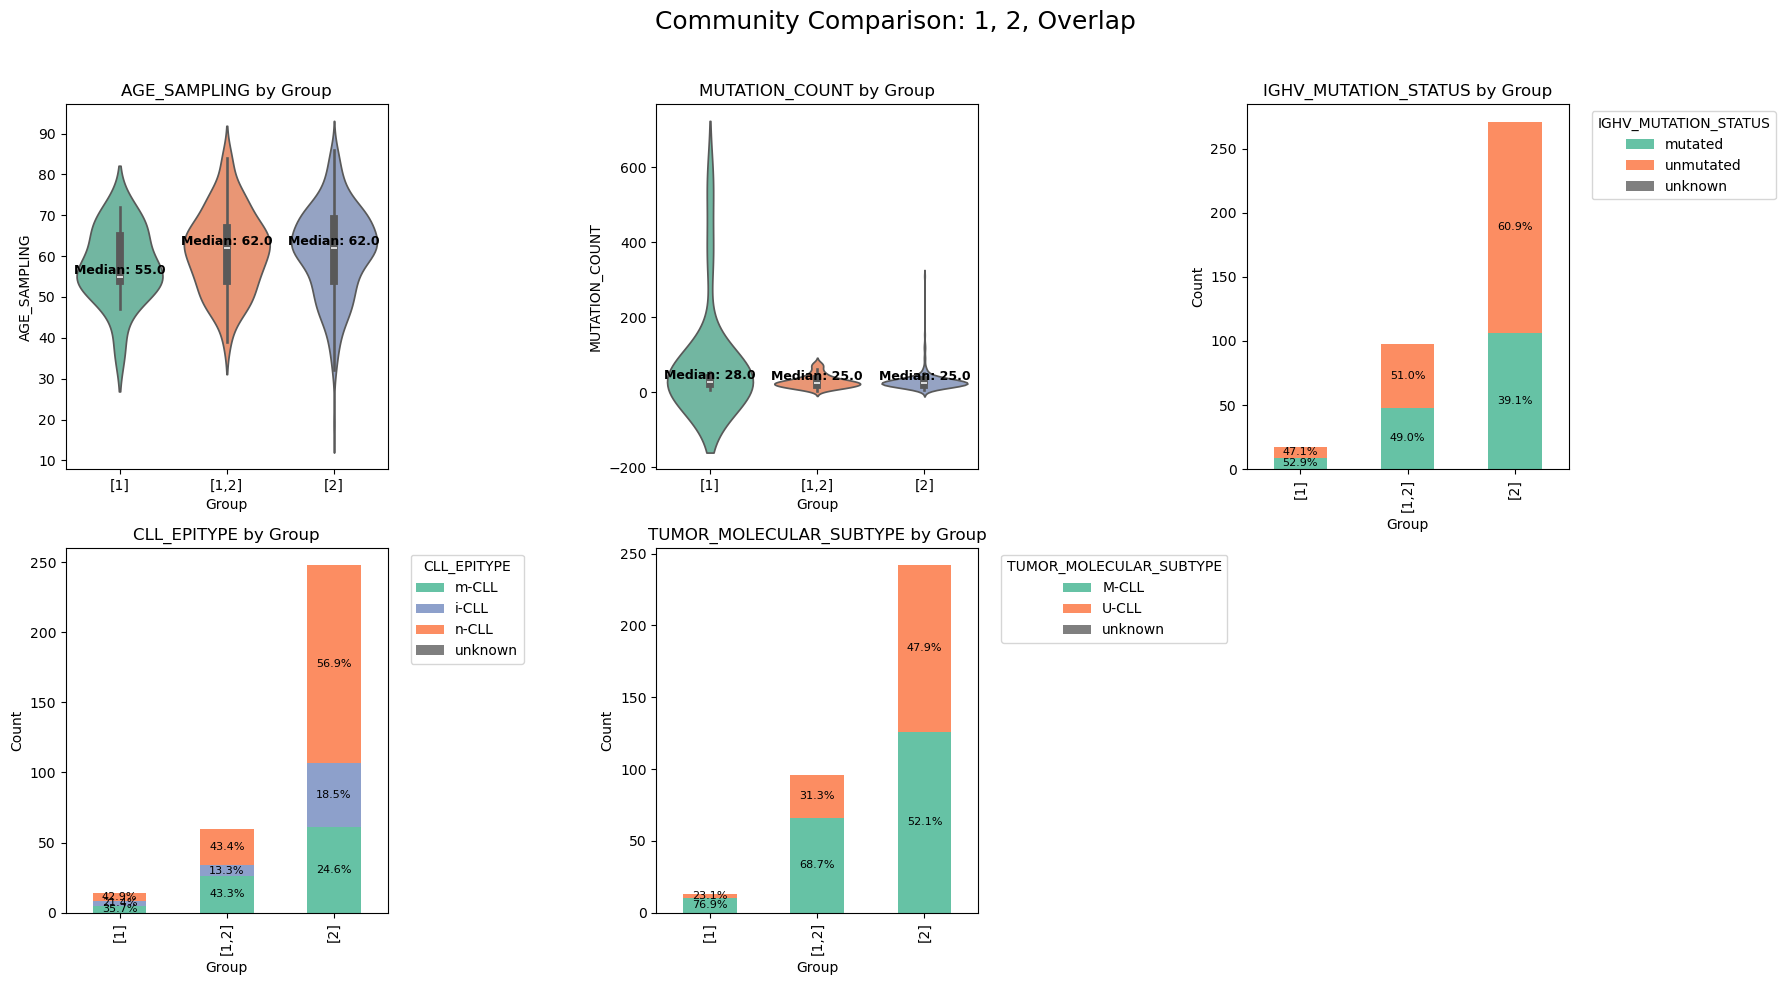

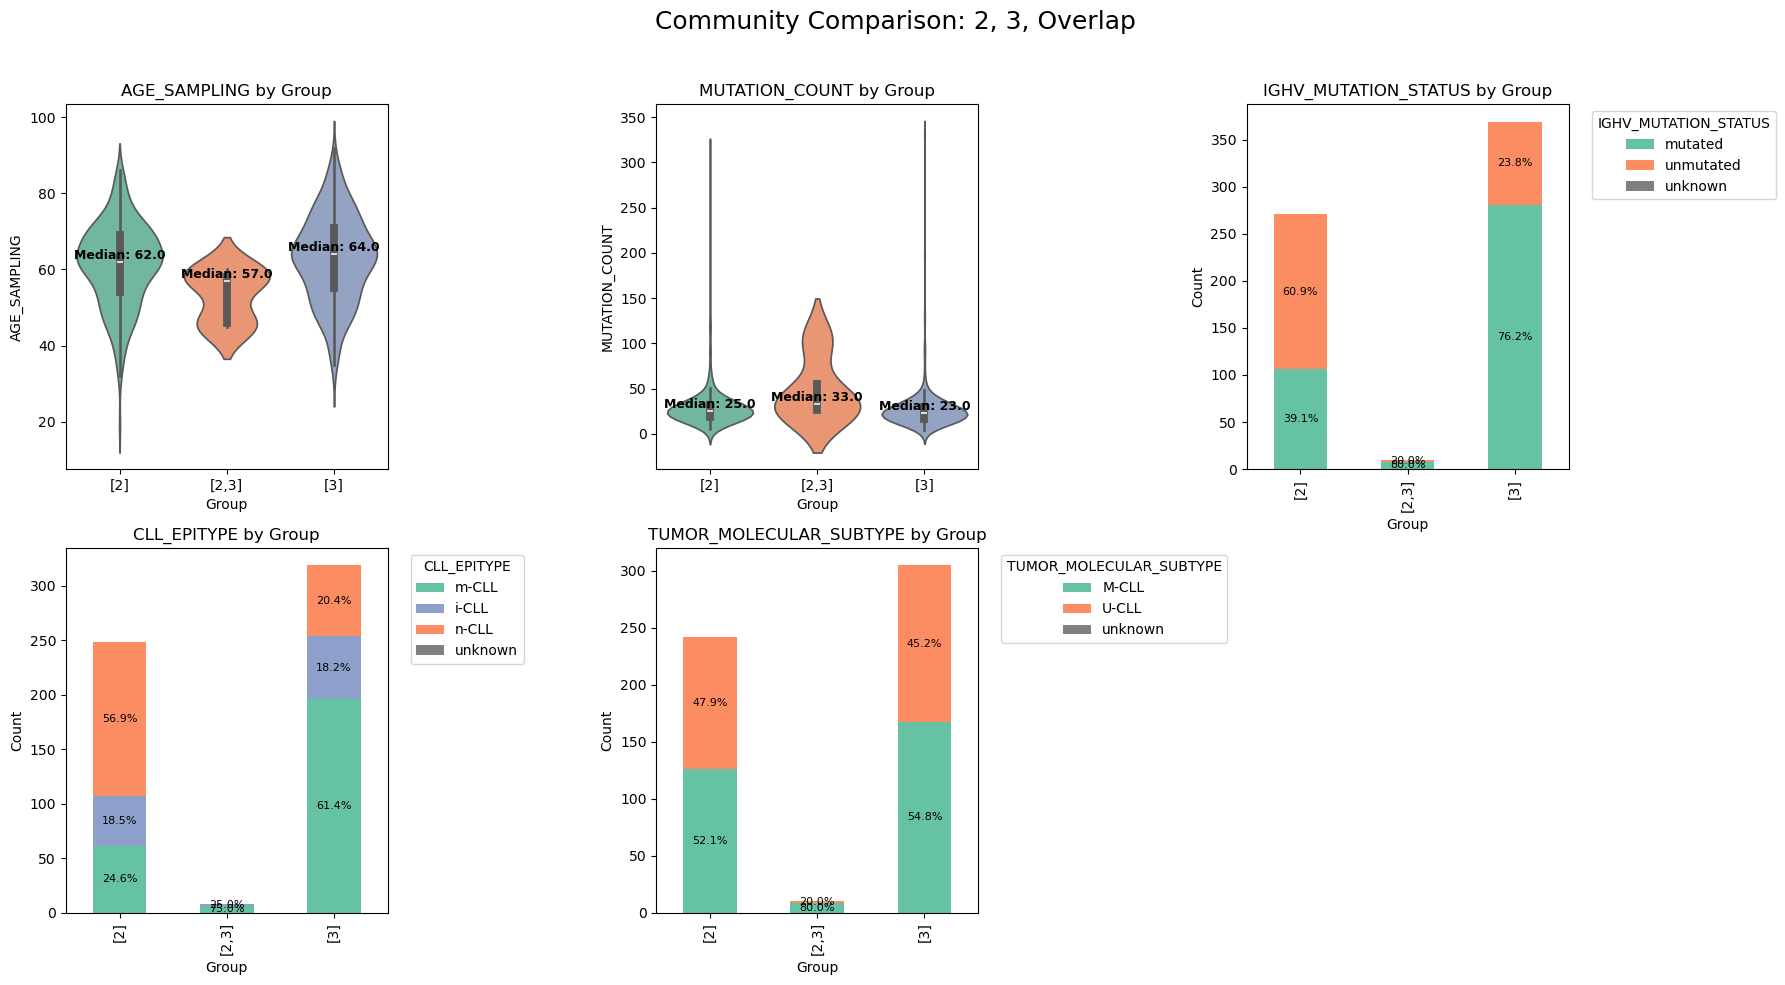

In [81]:
# legend_mapping from slpa_figures
cll_epitype_colors = {
    'm-CLL': '#66c2a5',
    'i-CLL': '#8da0cb', 
    'n-CLL': '#fc8d62',
    'unknown': '#7f7f7f',
}

tumor_colors = {
    'M-CLL': '#66c2a5',
    'U-CLL': '#fc8d62',
    'unknown': '#7f7f7f',
}

ighv_colors = {
    'mutated': '#66c2a5',
    'unmutated': '#fc8d62',
    'unknown': '#7f7f7f',
}


legend_mapping = {
    'CLL_EPITYPE': cll_epitype_colors,
    'TUMOR_MOLECULAR_SUBTYPE': tumor_colors,
    'IGHV_MUTATION_STATUS': ighv_colors
}

for comm_pair in [(1,2), (2,3)]:
    group_dict = get_overlap_groups(community_df, *comm_pair)
    plot_overlap_group_figure(merged, comm_pair[0], comm_pair[1], group_dict, legend_mapping)

## Plot for Each Overlap Set

In [82]:
def plot_overlap_group_figure(
    merged, comm1, comm2, group_dict, 
    legend_mapping, 
    numeric_features=['AGE_SAMPLING', 'MUTATION_COUNT'],
    categorical_features=['IGHV_MUTATION_STATUS', 'CLL_EPITYPE', 'TUMOR_MOLECULAR_SUBTYPE'],
    figsize=(18, 10)
):
    """
    merged: merged DataFrame with patient info
    comm1, comm2: int, community ids
    group_dict: dict with keys '[comm1]', '[comm2]', '[comm1,comm2]' and sets of patientIds
    legend_mapping: dict of {feature: {category: color}}
    """
    # Order: comm1, overlap, comm2
    group_labels = [f'[{comm1}]', f'[{comm1},{comm2}]', f'[{comm2}]']
    # Build DataFrame with group label
    group_dfs = []
    for label in group_labels:
        ids = group_dict[label]
        sub = merged[merged['patientId'].isin(ids)].copy()
        sub['overlap_group'] = label
        group_dfs.append(sub)
    plot_df = pd.concat(group_dfs, axis=0)
    
    # Layout: 2 rows × 3 cols (last cell empty)
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Violin plots
    for i, feature in enumerate(numeric_features):
        ax = axes[i]
        sns.violinplot(
            data=plot_df, x='overlap_group', y=feature, 
            order=group_labels, ax=ax, palette='Set2', inner='box'
        )
        ax.set_title(f"{feature} by Group")
        ax.set_xlabel("Group")
        ax.set_ylabel(feature)
        for j, group in enumerate(group_labels):
            median = plot_df[plot_df['overlap_group'] == group][feature].median()
            ax.axhline(median, color=sns.color_palette('Set2')[j], linestyle='--', linewidth=1)
            ax.text(j, median, f"Median: {median:.1f}", color='black', va='bottom', ha='center', fontsize=9, fontweight='bold')
    
    # Stacked bar plots
    for k, feature in enumerate(categorical_features):
        ax = axes[2 + k]
        ct = pd.crosstab(plot_df['overlap_group'], plot_df[feature])
        # Use legend mapping for order and color
        category_map = legend_mapping[feature]
        ordered_cats = list(category_map.keys())
        ct = ct.reindex(index=group_labels, columns=ordered_cats, fill_value=0)
        colors = [category_map[k] for k in ordered_cats]
        ct.plot(kind='bar', stacked=True, ax=ax, color=colors)
        ax.set_title(f"{feature} by Group")
        ax.set_xlabel("Group")
        ax.set_ylabel("Count")
        handles, labels_ = ax.get_legend_handles_labels()
        ax.legend(handles, ordered_cats, bbox_to_anchor=(1.05, 1), loc='upper left', title=feature)
        # Annotate with percent (rounded to 1dp, sum to 100)
        for bar_idx, group in enumerate(ct.index):
            y_bottom = 0
            row_counts = ct.loc[group].values
            total = row_counts.sum()
            if total == 0:
                continue
            raw = [v / total * 100 for v in row_counts]
            rounded = [np.floor(x * 10) / 10 for x in raw]
            diff = round(100 - sum(rounded), 1)
            remainders = [x - np.floor(x * 10) / 10 for x in raw]
            idxs = np.argsort(remainders)[::-1]
            i = 0
            while abs(diff) > 1e-6:
                rounded[idxs[i % len(rounded)]] += 0.1
                diff = round(100 - sum(rounded), 1)
                i += 1
            rounded = [round(x, 1) for x in rounded]
            for cat_idx, cat in enumerate(ordered_cats):
                value = ct.loc[group, cat]
                if value == 0:
                    continue
                text = f"{rounded[cat_idx]:.1f}%"
                y = y_bottom + value / 2
                ax.annotate(
                    text,
                    (bar_idx, y),
                    ha='center', va='center', fontsize=8, color='black'
                )
                y_bottom += value
    
    # Hide last subplot if unused
    if len(axes) > 5:
        axes[5].axis('off')
    plt.suptitle(f"Community Comparison: {comm1}, {comm2}, Overlap", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Venn Diagrams for Mutations and Treatments

In [83]:
def get_top_features_for_venn(mutation_df, group_dict, feature, top_n=10):
    """
    Returns dict: {group_label: set of top N features}
    and dict: {group_label: {feature: percent}}
    """
    top_sets = {}
    percent_dict = {}
    for label, ids in group_dict.items():
        sub = mutation_df[mutation_df['patientId'].isin(ids)]
        total = len(set(ids))
        if total == 0:
            top_sets[label] = set()
            percent_dict[label] = {}
            continue
        # Compute percent of patients with each feature
        feat_pct = {}
        for f in sub[feature].unique():
            n_patients = sub[sub[feature]==f]['patientId'].nunique()
            feat_pct[f] = round(n_patients/total*100, 1)
        # Take top_n by percentage
        top_feats_sorted = sorted(feat_pct.items(), key=lambda x: -x[1])[:top_n]
        top_feats = set([f for f, pct in top_feats_sorted])
        feat_pct = {f: pct for f, pct in top_feats_sorted}
        top_sets[label] = top_feats
        percent_dict[label] = feat_pct
    return top_sets, percent_dict

def plot_venn3_with_percents(top_sets, percent_dict, group_labels, title, save_prefix=None):
    sets = [top_sets[label] for label in group_labels]
    fig, ax = plt.subplots(figsize=(10,8))
    v = venn3(subsets=sets, set_labels=group_labels, ax=ax)
    # Annotate each region
    from matplotlib_venn import venn3_circles
    venn3_circles(subsets=sets, ax=ax)
    # For each region, get the features and annotate with percent (intersection: overlap group only)
    # Only annotate the top_n features in each group
    for idx, region in enumerate(['100','010','001','110','101','011','111']):
        label = v.get_label_by_id(region)
        if label is None:
            continue
        region_set = v.get_patch_by_id(region)
        if region_set is None:
            continue
        # For unique regions
        # if region == '100':
        #     feats = sets[0] - sets[1] - sets[2]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[0]].get(f,0):.1f}%)" for f in feats])
        # elif region == '010':
        #     feats = sets[1] - sets[0] - sets[2]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[1]].get(f,0):.1f}%)" for f in feats])
        # elif region == '001':
        #     feats = sets[2] - sets[0] - sets[1]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[2]].get(f,0):.1f}%)" for f in feats])
        # # [1,2] overlaps with 1 (region '110')
        # elif region == '110':
        #     feats = (sets[0] & sets[1]) - sets[2]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[1]].get(f,0):.1f}%)" for f in feats])
        # # [1,2] overlaps with 2 (region '011')
        # elif region == '011':
        #     feats = (sets[1] & sets[2]) - sets[0]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[2]].get(f,0):.1f}%)" for f in feats])
        # # 1 overlaps with 2 (region '101')
        # elif region == '101':
        #     feats = (sets[0] & sets[2]) - sets[1]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[2]].get(f,0):.1f}%)" for f in feats])
        # # Intersection of all three
        # elif region == '111':
        #     feats = sets[0] & sets[1] & sets[2]
        #     text = '\n'.join([f"{f} ({percent_dict[group_labels[2]].get(f,0):.1f}%)" for f in feats])
        # else:
        #     text = ''
        # skips percent_dict for now
        if region == '100':
            feats = sets[0] - sets[1] - sets[2]
            text = '\n'.join([f"{f}" for f in feats])
        elif region == '010':
            feats = sets[1] - sets[0] - sets[2]
            text = '\n'.join([f"{f}" for f in feats])
        elif region == '001':
            feats = sets[2] - sets[0] - sets[1]
            text = '\n'.join([f"{f}" for f in feats])
        elif region == '110':
            feats = (sets[0] & sets[1]) - sets[2]
            text = '\n'.join([f"{f}" for f in feats])
        elif region == '011':
            feats = (sets[1] & sets[2]) - sets[0]
            text = '\n'.join([f"{f}" for f in feats])
        elif region == '101':
            feats = (sets[0] & sets[2]) - sets[1]
            text = '\n'.join([f"{f}" for f in feats])
        elif region == '111':
            feats = sets[0] & sets[1] & sets[2]
            text = '\n'.join([f"{f}" for f in feats])
        else:
            text = ''
        label.set_text(text)
    ax.set_title(title)
    plt.tight_layout()
    # if save_prefix:
        # plt.savefig(f"{save_prefix}.png", dpi=300, bbox_inches='tight')
    plt.show()

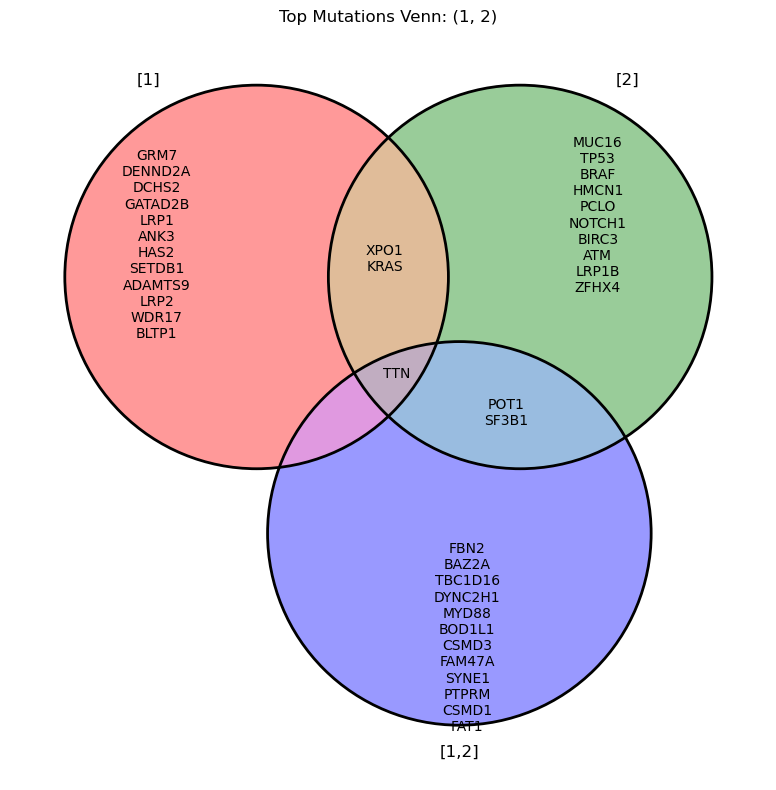

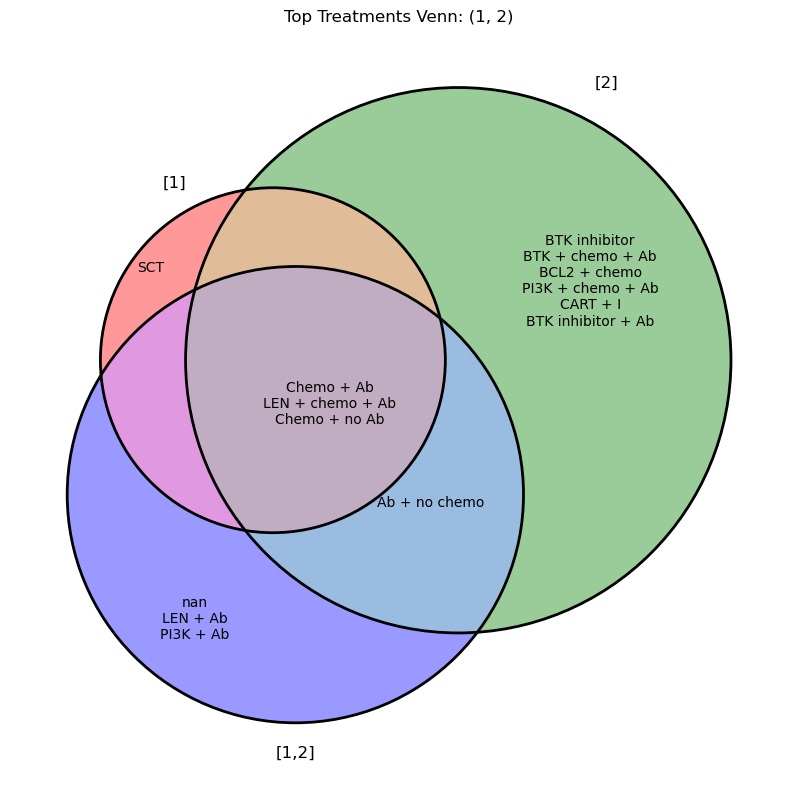

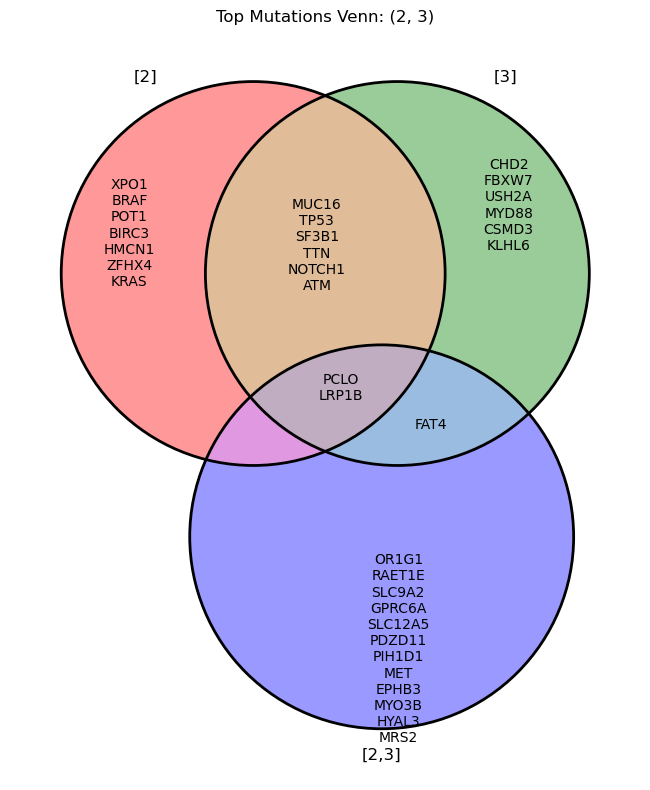

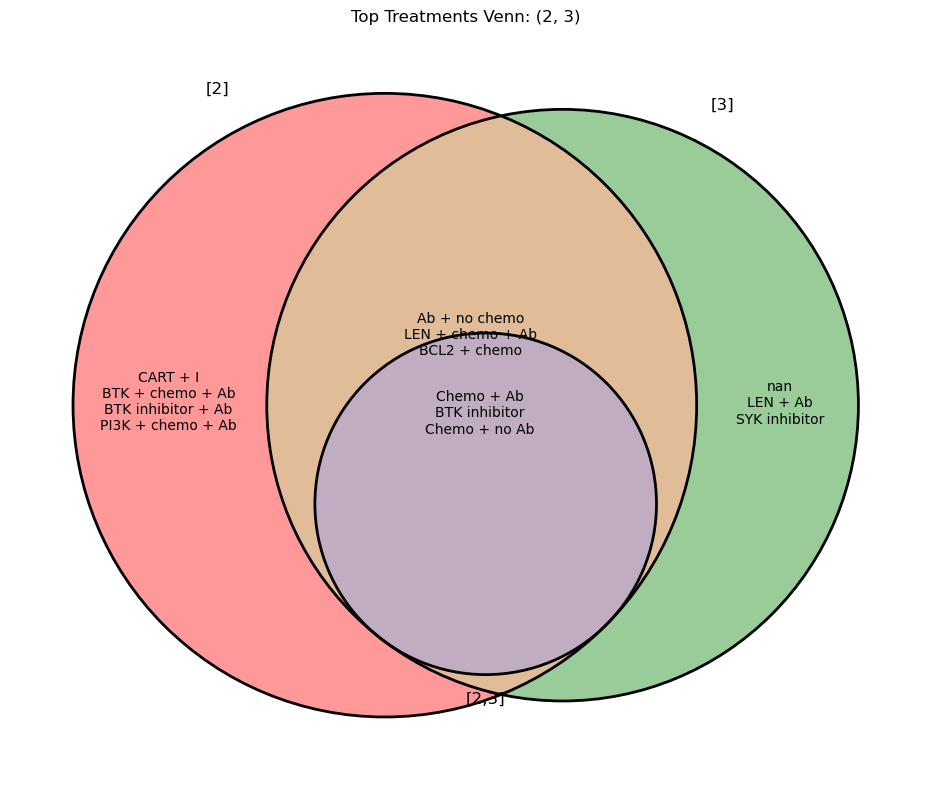

In [84]:
# Example for mutations and treatments
for comm_pair in [(1,2), (2,3)]:
    group_dict = get_overlap_groups(community_df, *comm_pair)
    group_labels = list(group_dict.keys())
    # Mutations
    top_sets, percent_dict = get_top_features_for_venn(mutation_df, group_dict, 'hugoGeneSymbol', top_n=15)
    plot_venn3_with_percents(top_sets, percent_dict, group_labels, f"Top Mutations Venn: {comm_pair}", save_prefix=f"venn_mutations_{comm_pair[0]}_{comm_pair[1]}")
    # Treatments
    top_sets, percent_dict = get_top_features_for_venn(merged, group_dict, 'TREATMENT_AFTER_SAMPLING', top_n=10)
    plot_venn3_with_percents(top_sets, percent_dict, group_labels, f"Top Treatments Venn: {comm_pair}", save_prefix=f"venn_treatments_{comm_pair[0]}_{comm_pair[1]}")